## functions
シグモイド関数, ステップ関数, ReLU関数をそれぞれ定義してプロットした

In [1]:
import Base: convert
convert(::Type{Integer}, x::Bool) = x ? 1 : 0

# dot: vectorize calucuration
sigmoid(x) = 1 ./ (1 .+ exp.(-x))
step(x) = convert.(Integer, x .> 0)
relu(x) = max.(0, x)

function softmax(x)
    x = x .- maximum(x)
    return exp.(x) / sum(exp.(x))
end

softmax (generic function with 1 method)

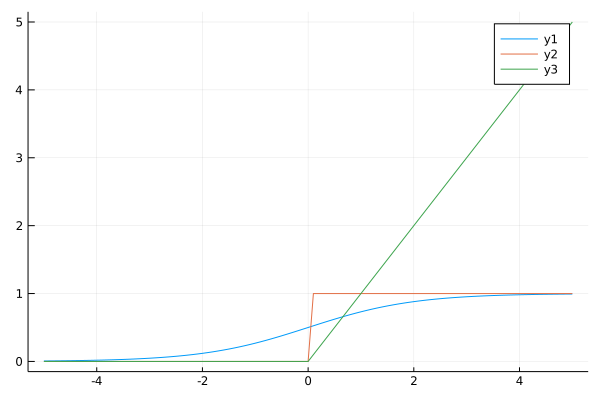

In [2]:
using Plots

x = -5.0:0.1:5.0

plot(x, [sigmoid(x), step(x), relu(x)])

## Loading MNIST Data
MNISTから手書き数字の画像データを取得し, Plotsを使って画像を表示した

In [5]:
using PyCall

pickle = pyimport("pickle")

function get_dataset()
    dataset = nothing
    @pywith pybuiltin("open")("dataset/mnist.pkl", "rb") as f begin
        dataset = pickle.load(f)
    end
    return dataset
end

function load_mnist(;normalize=true, flatten=true, one_hot_label=false)
    dataset = get_dataset()

    train_n = length(dataset["train_img"])
    test_n = length(dataset["test_img"])
        
    train_imgs = reshape(dataset["train_img"].flatten(), (28 * 28, :))
    test_imgs = reshape(dataset["test_img"].flatten(), (28 * 28, :))

    train_imgs = convert(Array{Float32}, train_imgs)
    test_imgs = convert(Array{Float32}, test_imgs)
    
    if normalize
        train_imgs = train_imgs ./ 255.0
        test_imgs = test_imgs ./ 255.0
    end
    
    if !flatten 
        train_imgs = reshape(train_imgs, (28, 28, :))
        test_imgs = reshape(test_imgs, (28, 28, :))
    end

    return (train_imgs, dataset["train_label"]),
        (test_imgs, dataset["test_label"])
end

load_mnist (generic function with 1 method)

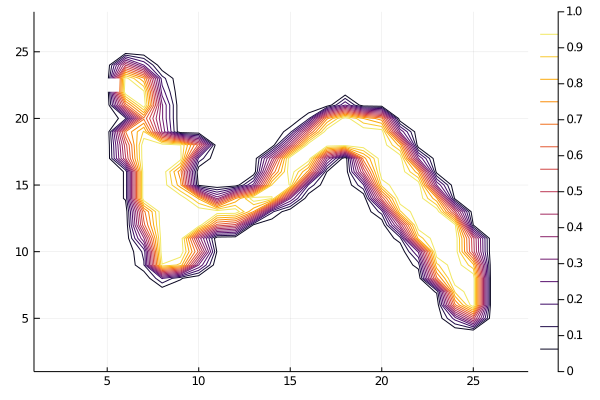

In [6]:
using Images
using ImageView
using Plots

# push!(PyVector(pyimport("sys")["path"]), "")
# @pyimport dataset.mnist as mnist
# (x_train, t_train), (x_test, t_test) = mnist.load_mnist(flatten=true, normalize=false)

(x_train, t_train), (x_test, t_test) = load_mnist(flatten=false)

plot(1:28, 1:28, x_train[:, :, 1])

## Neuralnet
学習済みデータを用いて, MNISTのデータを解析した

In [18]:
function init_network()
    network = nothing
    @pywith pybuiltin("open")("sample_weight.pkl", "rb") as f begin
        network = pickle.load(f)
    end
    return network
end

dot_arr_mat(arr, mat) = transpose(transpose(arr) * mat)
    
function predict(network, x)
    a1 = dot_arr_mat(x, network["W1"]) + network["b1"]
    z1 = sigmoid(a1)

    a2 = dot_arr_mat(z1, network["W2"]) + network["b2"]
    z2 = sigmoid(a2)

    a3 = dot_arr_mat(z2, network["W3"]) + network["b3"]
    y = softmax(a3)

    return y
end

predict (generic function with 2 methods)

In [19]:
(x_train, t_train), (x_test, t_test) = load_mnist()

network = init_network()

y = map(x -> predict(network, x), eachrow(transpose(x_test)))

10000-element Array{Array{Float64,1},1}:
 [8.441250325382645e-5, 2.6350644827380224e-6, 0.0007154942379498242, 0.0012586262464386064, 1.1727950968137609e-6, 4.499082177856484e-5, 1.6269317442735082e-8, 0.9970649659306068, 9.374473359791482e-6, 0.0008183116577155315]
 [0.0048363307769332215, 0.0011045859406722115, 0.944252241212036, 0.014309134931807722, 5.698956577471126e-7, 0.006676040726976596, 0.02753335432500692, 1.2708434883562525e-6, 0.0012864234827370592, 4.78646841013213e-8]
 [1.0358303462444478e-7, 0.9889725891785791, 0.00428948968389472, 0.001783208765900586, 0.00013173360178049334, 0.0007594074383308898, 0.00046890993910482536, 0.0022699729860157203, 0.0012378701453587126, 8.6714678000364e-5]
 [0.9941147779891886, 8.211479163588305e-8, 0.0015906465319434292, 0.00018977529590100025, 4.321234893605567e-6, 0.003371397624827256, 0.0004066295704321949, 0.00023197011257957141, 4.836023793601331e-5, 4.2039287506557754e-5]
 [0.00020664289215094483, 6.5650999036163946e-6, 0.002890032

In [45]:
rsts = map(x -> argmax(x) - 1, y)
t = t_test.tolist()
count = length(t[t .== rsts])
count / size(x_test, 2)

0.9352

## Notes

In [338]:
(x_train, t_train), (x_test, t_test) = load_mnist()

dot_arr_mat(arr, mat) = transpose(transpose(arr) * mat)

a1 = dot_arr_mat(x_test[:, 1], network["W1"]) + network["b1"]
z1 = sigmoid(a1)

50-element Array{Float64,1}:
 0.4921465776018378
 0.9334590793671805
 0.8866169989308034
 0.7543360588771586
 0.8261771946480926
 0.9920472432938636
 0.9159966832760563
 0.1070493746011847
 0.5978546424126189
 0.6351972559980015
 0.5153490319473673
 0.4288016463774616
 0.5631834670431617
 ⋮
 0.9226262537614086
 0.30158925790004726
 0.511486544096229
 0.696628620692819
 0.8955399016171958
 0.871828927311257
 0.005162535061515874
 0.945757337150872
 0.8761556126407424
 0.833853564014417
 0.028261321123044594
 0.7925501597571926

In [340]:
a2 = dot_arr_mat(z1, network["W2"]) + network["b2"]
z2 = sigmoid(a2)

100-element Array{Float64,1}:
 0.18541109099473949
 0.8883186285472177
 0.1992796734665964
 0.846190097309897
 0.6594410102653773
 0.7895216501171707
 0.5743944378161896
 0.6867535378991526
 0.29696422702844566
 0.3041733463317512
 0.7898073252341913
 0.5719543563037487
 0.6004423326715865
 ⋮
 0.10923526234213578
 0.5231975570544686
 0.5094236108944311
 0.7559400490625638
 0.14035060305154098
 0.4489409382437107
 0.4502875441206801
 0.2186402933585213
 0.21168273584211222
 0.27542490255938623
 0.8301006054690866
 0.39710089328717457

In [343]:
a3 = dot_arr_mat(z2, network["W3"]) + network["b3"]

10-element Array{Float64,1}:
  0.09678575798879813
 -3.3700221221376654
  2.2340437703253393
  2.798846349094083
 -4.179539904069638
 -0.5324712669676834
 -8.457404085980993
  9.473641432777015
 -2.100939380135871
  2.3683134882341497

In [355]:
y = softmax(a3)

10-element Array{Float64,1}:
 8.441250325382645e-5
 2.6350644827380224e-6
 0.0007154942379498242
 0.0012586262464386064
 1.1727950968137609e-6
 4.499082177856484e-5
 1.6269317442735082e-8
 0.9970649659306068
 9.374473359791482e-6
 0.0008183116577155315

In [161]:
function get_dataset()
    dataset = nothing
    @pywith pybuiltin("open")("dataset/mnist.pkl", "rb") as f begin
        dataset = pickle.load(f)
    end
    return dataset
end

dataset = get_dataset()

Dict{Any,Any} with 4 entries:
  "train_img"   => PyObject array([[0, 0, 0, ..., 0, 0, 0],…
  "train_label" => PyObject array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)
  "test_img"    => PyObject array([[0, 0, 0, ..., 0, 0, 0],…
  "test_label"  => PyObject array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [164]:
convert(Array{Float32}, dataset["train_img"].flatten())

47040000-element Array{Float32,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0